In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')



In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis
from polarity.dynamics import EllipsoidLameGeometry as geom
#from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom


In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190620_one_fold_clone')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

In [5]:
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [6]:
"""
Mesoderm invagination event module
=======================


"""

import random
import numpy as np

from tyssue.utils.decorators import face_lookup
from tyssue.behaviors.sheet.actions import relax, contract, ab_pull
from tyssue.behaviors.sheet.basic_events import contraction


default_constriction_spec = {
    "face_id": -1,
    "face": -1,
    "contract_rate": 2,
    "critical_area": 1e-2,
    "radial_tension": 1.0,
    "contract_neighbors": True,
    "critical_area_neighbors": 10,
    "contract_span": 2,
    "basal_contract_rate": 1.001,
    "current_traction": 0,
    "max_traction": 30,
    "contraction_column": "contractility",
}


@face_lookup
def delamination(sheet, manager, **kwargs):
    """Constriction process
    This function corresponds to the process called "apical constriction"
    in the manuscript
    The cell undergoing delamination first contracts its apical
    area until it reaches a critical area. A probability
    dependent to the apical area allow an apico-basal
    traction of the cell. The cell can pull during max_traction
    time step, not necessarily consecutively.
    Parameters
    ----------
    sheet : a :class:`tyssue.sheet` object
    manager : a :class:`tyssue.events.EventManager` object
    face_id : int
       the Id of the face undergoing delamination.
    contract_rate : float, default 2
       rate of increase of the face contractility.
    critical_area : float, default 1e-2
       face's area under which the cell starts loosing sides.
    radial_tension : float, default 1.
       tension applied on the face vertices along the
       apical-basal axis.
    contract_neighbors : bool, default `False`
       if True, the face contraction triggers contraction of the neighbor
       faces.
    contract_span : int, default 2
       rank of neighbors contracting if contract_neighbor is True. Contraction
       rate for the neighbors is equal to `contract_rate` devided by
       the rank.
    """
    constriction_spec = default_constriction_spec
    constriction_spec.update(**kwargs)

    # initialiser une variable face
    # aller chercher la valeur dans le dictionnaire à chaque fois ?
    face = constriction_spec["face"]
    contract_rate = constriction_spec["contract_rate"]
    current_traction = constriction_spec["current_traction"]

    
    
    face_area = sheet.face_df.loc[face, "area"]

    if face_area > constriction_spec["critical_area"]:
        contract(
            sheet,
            face,
            contract_rate,
            True,
            constriction_spec["contraction_column"],
        )
        # if sheet.face_df.loc[face, 'prefered_area'] > 6:
        #    sheet.face_df.loc[face, 'prefered_area'] -= 0.5
        # increase_linear_tension(sheet, face, contract_rate)

        if (constriction_spec["contract_neighbors"]) & (
            face_area < constriction_spec["critical_area_neighbors"]
        ):
            neighbors = sheet.get_neighborhood(
                face, constriction_spec["contract_span"]
            ).dropna()
            neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values

            manager.extend(
                [
                    (
                        contraction,
                        _neighbor_contractile_increase_delamination(neighbor, constriction_spec),
                    )  # TODO: check this
                    for _, neighbor in neighbors.iterrows()
                ]
            )

    proba_tension = np.exp(-face_area / constriction_spec["critical_area"])
    aleatory_number = random.uniform(0, 1)
    if current_traction < constriction_spec["max_traction"]:
        if aleatory_number < proba_tension:
            current_traction = current_traction + 1
            ab_pull(sheet, face, constriction_spec["radial_tension"], True)
            constriction_spec.update({"current_traction": current_traction})

    manager.append(delamination, **constriction_spec)


def _neighbor_contractile_increase_delamination(neighbor, constriction_spec):

    contract = constriction_spec["contract_rate"]
    basal_contract = constriction_spec["basal_contract_rate"]

    increase = (
        -(contract - basal_contract) / constriction_spec["contract_span"]
    ) * neighbor["order"] + contract

    specs = {
        "face_id": neighbor["id"],
        "contractile_increase": increase,
        "critical_area": constriction_spec["critical_area"],
        "max_contractility": 50,
        "contraction_column": constriction_spec["contraction_column"],
        "multiple": True,
        "unique": False,
    }

    return specs


In [7]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    h5store = '../examples/superegg_final.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    
    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)
    
    sheet = Sheet('spherical', datasets, specs)
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_volume_elasticity'] = 3.e-6
    #sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100

    return sheet

sheet = load_before_apopto(0)

geom.update_all(sheet)



KeyError: 'barrier_ray'

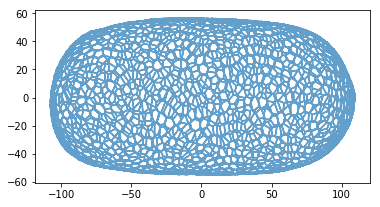

In [8]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
theta = np.linspace(0, 2*np.pi, 100)

x = np.cos(theta)*sheet.settings['barrier_ray']
y = np.sin(theta)*sheet.settings['barrier_ray']
ax.plot(x,y)
#ax.axhline(55, color='r')
#ax.axhline(-55, color='r')
fig.set_size_inches(18.5, 10.5, forward=True)

KeyError: 'barrier_ray'

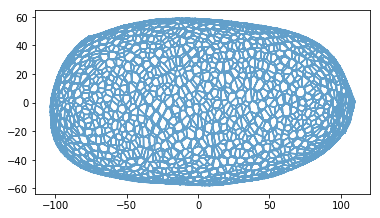

In [9]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
theta = np.linspace(0, 2*np.pi, 100)

x = np.cos(theta)*sheet.settings['barrier_ray']
y = np.sin(theta)*sheet.settings['barrier_ray']
ax.plot(x,y)
fig.set_size_inches(18.5, 10.5, forward=True)

In [10]:
"""import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig"""
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'white'},
                      face={'color':'black', 'visible':True})
fig



Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('white', dtype='<U5'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array('black', dtype='<U5'), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [11]:
def define_fold_position(sheet, fold_number = 2, position=[-36, -22, 22, 36]):
    #position = [min, max, min, max]
    sheet.face_df['fold'] = 0
    for i in range(fold_number):
        i=i*2
        sheet.face_df.loc[sheet.face_df[(sheet.face_df.z>position[i]) 
                                        & (sheet.face_df.z<position[i+1])].index, 'fold'] = i+1
        
        
        
define_fold_position(sheet, fold_number = 1, position=[-7, 7])
print(len(sheet.face_df[sheet.face_df.fold==1]))
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


113


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightslategrey', dtype='<U14'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [36]:
#Add clone cell
#clone of 4 cells

sheet.face_df['is_mesoderm']=0
index_clone_cells = sheet.face_df[(sheet.face_df.z>20) & (sheet.face_df.z<33) 
              & (sheet.face_df.y>41)&(sheet.face_df.y<51)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold+sheet.face_df.is_mesoderm,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightslategrey', dtype='<U14'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [25]:
sheet.face_df['apoptosis'] = 0


def apoptosis_ventral (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.6*np.exp(-(i.phi+3)**2/0.7**2) + 0.6*np.exp(-(i.phi-3)**2/0.7**2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 1
        


apoptosis_ventral(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightslategrey', dtype='<U14'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [26]:
def apoptosis_lateral (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.3*np.exp(-(i.phi+1.5)**2/0.8**2) + 0.3*np.exp(-(i.phi-1.5)**2/0.8**2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 2
        


apoptosis_lateral(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightslategrey', dtype='<U14'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [33]:
def apoptosis_dorsal (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.2*np.exp(-(i.phi)**2/0.4*2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 3
        


apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightslategrey', dtype='<U14'), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-16.24229665,  -6.36545131,  -5.35211801, ...,  61.21090859,
        60.97425386,  52.80559743]), y=array([ -7.91526583,   7.21032949, -11.45101628, ...,  33.25593943,
       -48.48026853, -50.80571962]), z=array([ 57.14715693,  57.64845669,  56.84259524, ..., -38.85622957,
        -3.3444838 ,  -6.57379168])), Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-15.56336958, -13.87037085, -25.20547551, ...,  52.83935532,
        58.0996793 ,  52.83935532]), y=array([ -3.98872782, -10.53230642, -14.25317465, ..., -50.74933131,
       -48.93464919, -50.74933131]), z=array([57.40989852, 56.79386021, 54.76213058, ..., -6.55220353,
       -7.33862   , -6.55220353]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-113.94562206950678, 120.34243446335152], ylim=[-113.94562206950678, 120.34243446335152], zlim=[-113.94562206950678, 120.34243446335152])

In [34]:
len(sheet.face_df[sheet.face_df.apoptosis>0])

34

In [35]:
len(sheet.face_df[sheet.face_df.fold>0])

113

In [36]:
len(sheet.face_df[sheet.face_df.apoptosis==1])

14

In [37]:
len(sheet.face_df[sheet.face_df.apoptosis==2])

16

In [38]:
len(sheet.face_df[sheet.face_df.apoptosis==3])

4

In [39]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass

    
    apoptosis_settings = {
        "critical_area": 5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":30,
        "current_traction":0,
        "geom": geom,
    }
    
    delaminate_settings = {'critical_area': 1e-2,
                'radial_tension': radial_tension*150/100,
                'nb_iteration': 0,
                'nb_iteration_max': 200,
                'contract_neighbors': True,
                'critical_area_neighbors': 12,
                'contract_span': 2,
                'basal_contract_rate': 1.001,
                'geom': geom,
                'contraction_column': 'contractility'}
    
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    sheet2.settings['delamination'] = delaminate_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, options={"gtol": 1e-8})


    sheet2 = apoptosis_process(dirname, solver, sheet2, geom, model)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [40]:
def apoptosis_process(dirname, solver, sheet, geom, model):
    
    # Initiate manager
    manager = EventManager('face')
    
    t = 0
    stop = 150
    
    
    
    # Run simulation
    while t < stop:
        
        
        if t == 7 : 
            for i in index_clone_cells:
                delamination_kwargs = sheet.settings['delamination'].copy()
                delamination_kwargs.update(
                        {
                            'face_id': i,
                        }
                    )
                manager.append(delamination, **delamination_kwargs)
        
        
        if t%10 == 0:
            sheet.settings['lumen_prefered_vol'] *= 0.99        
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t == 1 :
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 1].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        if t == 11 : 
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 2].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
                
        if t == 21:
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 3].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
    
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        
        
        with pd.HDFStore(hdfname) as test:
            test.put("settings", pd.Series(sheet.settings))

        with pd.HDFStore(hdfname) as store:
            settings = store['settings']
        
        hdf5.save_datasets(hdfname, sheet)



        manager.update()
        t += 1

    return sheet


In [ ]:
# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

radial_tension = [30]

#for rd in radial_tension:
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

for lt in line_tension:
    for c in contractility_rate:
        for rd in radial_tension:
            for iteration in range (0, 1):
                run_sim(sim_save_dir, sheet, c, rd, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

radial_tension = [0,10,20,30,40]

#for rd in radial_tension:
#contractility_percent = [2, 4, 8, 16, 32]
contractility_percent = [32]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, 0) 
                             for c, rd in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-06-20 11:35:55.947787
starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_0_radialtension0
starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_10_radialtension0


/home/admin-suz/anaconda3/lib/python3.6/site-packages/joblib/parallel.py:131: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/home/admin-suz/anaconda3/lib/python3.6/site-packages/joblib/parallel.py:131: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  return [func(*args, **kwargs) for func, args, kwargs in self.items]


/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_10_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_20_radialtension0
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_0_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_30_radialtension0
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_20_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_40_radialtension0


In [ ]:
sheet.settings2 = pd.DataFrame.from_dict(sheet.settings, orient='index')

In [ ]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis')
dirname = SIM_DIR/'1.08_constriction_50_radialtension0_line_tension100/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0145.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
"""sheet.face_df['test']=0
index =sheet.face_df[(sheet.face_df.z>6) & (sheet.face_df.z<15) 
              & (sheet.face_df.y>25) & (sheet.face_df.y<35) 
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index, 'test']=1"""

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y,
            #'colormap': 'Reds'
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.fold,
            'colormap': 'Blues'
        },
        'vert':{
            'visible':True,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension
            
        }
        
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

In [ ]:
sheet.settings['geometry'] = "spherical"
sheet.settings['lumen_vol_elasticity'] = 3.e-6
#sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100
sheet.settings['barrier_ray'] = int(max(np.abs(sheet.face_df.z.min()), sheet.face_df.z.max())+20)
sheet.vert_df['barrier_elasticity'] = 280.0
#sheet.settings['barrier_ray_cylinder'] = 55
sheet.edge_df['line_tension'] = 3
sheet.settings['lumen_prefered_vol']=1655117.87836963126/2

In [ ]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

In [ ]:
#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y,
            #'colormap': 'Reds'
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.fold,
            'colormap': 'Blues'
        },
        'vert':{
            'visible':True,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension
            
        }
        
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig